# Maximum Sharpe ratio portfolio on selected Danish stocks

In [1]:
from os import listdir
from os.path import isfile, join

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
import scipy.optimize as sco

In [2]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('cubehelix')
plt.rcParams['figure.figsize'] = [5.5, 3]
plt.rcParams['figure.dpi'] = 200

## Preprocess and load the data

In [4]:
%run preprocessing.py -n DK -i stock

In [7]:
close_df = pd.read_csv('..\data\DK\preprocessed_data\danish_closed_stocks.csv', index_col=0)

In [11]:
# Constants
danish_2y_yield = 0.03463
stocks_names = close_df.columns.tolist()

dividends = {stock: 0 for stock in stocks_names}
dividends['ORSTED'] = 2.14 / 100
dividends['MAERSK'] = 27.53 / 100
dividends['VWS'] = 0.0
dividends['CHR'] = 1.63 / 100
dividends['NOVO'] = 1.32 / 100
dividends['NZYM'] = 1.71 / 100
dividends['DNORD'] = 10.77 / 100
dividends['TRMD'] = 16.52 / 100
dividends['STG'] = 6.76 / 100
dividends['SOLAR'] = 7.26 / 100
dividends['AOJ'] = 6.32 /100
dividends['SKAKO'] = 7.99 / 100

dividends = pd.Series(dividends)

In [12]:
close_df.head()

,AOJ,CHR,DNORD,MAERSK,NOVO,NZYM,ORSTED,SKAKO,SOLAR,STG,TRMD,VWS,ZEAL
2016-06-09 09:00:00+02:00,21.20,417.10001,98.500000,8675.0,374.70001,310.10001,258.00000,58.5,334.5,109.0,71.5,92.820002,123.5
2016-06-10 09:00:00+02:00,21.35,408.00000,94.599998,8430.0,364.50000,303.00000,252.00000,57.0,326.0,108.4,65.5,89.820002,121.0
2016-06-13 09:00:00+02:00,21.34,401.70001,91.400002,8255.0,363.20001,302.60001,244.00000,55.0,316.0,106.0,66.5,88.000000,115.5
2016-06-14 09:00:00+02:00,21.34,394.70001,89.750000,7875.0,343.00000,296.89999,249.39999,53.5,310.0,105.0,64.5,85.940002,108.5
2016-06-15 09:00:00+02:00,21.34,397.00000,91.500000,8040.0,344.20001,302.10001,253.50000,57.0,312.5,105.2,65.0,86.479998,113.0


## EDA

In [13]:
returns_df = close_df.pct_change().dropna()
returns_df

,AOJ,CHR,DNORD,MAERSK,NOVO,NZYM,ORSTED,SKAKO,SOLAR,STG,TRMD,VWS,ZEAL
2016-06-10 09:00:00+02:00,0.007075,-0.021817,-0.039594,-0.028242,-0.027222,-0.022896,-0.023256,-0.025641,-0.025411,-0.005505,-0.083916,-0.032321,-0.020243
2016-06-13 09:00:00+02:00,-0.000468,-0.015441,-0.033827,-0.020759,-0.003567,-0.001320,-0.031746,-0.035088,-0.030675,-0.022140,0.015267,-0.020263,-0.045455
2016-06-14 09:00:00+02:00,0.000000,-0.017426,-0.018053,-0.046033,-0.055617,-0.018837,0.022131,-0.027273,-0.018987,-0.009434,-0.030075,-0.023409,-0.060606
2016-06-15 09:00:00+02:00,0.000000,0.005827,0.019499,0.020952,0.003499,0.017514,0.016439,0.065421,0.008065,0.001905,0.007752,0.006283,0.041475
2016-06-16 09:00:00+02:00,0.000000,0.015617,-0.026776,-0.027363,-0.016851,-0.020192,-0.010651,-0.035088,-0.035200,-0.013308,-0.007692,-0.022895,-0.048673
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-03 09:00:00+02:00,0.007916,0.003167,0.035253,0.035491,-0.015281,0.000315,0.000000,-0.006803,0.003960,0.018502,0.021315,-0.000882,-0.002453
2023-07-04 09:00:00+02:00,0.002618,0.010945,0.005675,0.024194,-0.002586,0.010063,-0.003412,0.000000,0.001972,0.013841,0.007752,0.010149,0.007377
2023-07-05 09:00:00+02:00,-0.005222,0.001041,-0.014108,-0.015748,0.015003,-0.000623,-0.024899,-0.020548,-0.011811,-0.008532,-0.009468,-0.026646,0.039870
2023-07-06 09:00:00+02:00,-0.010499,-0.003536,0.008014,-0.012800,-0.012591,-0.004050,-0.019470,0.013986,-0.014940,-0.003442,-0.010155,-0.012790,-0.020344


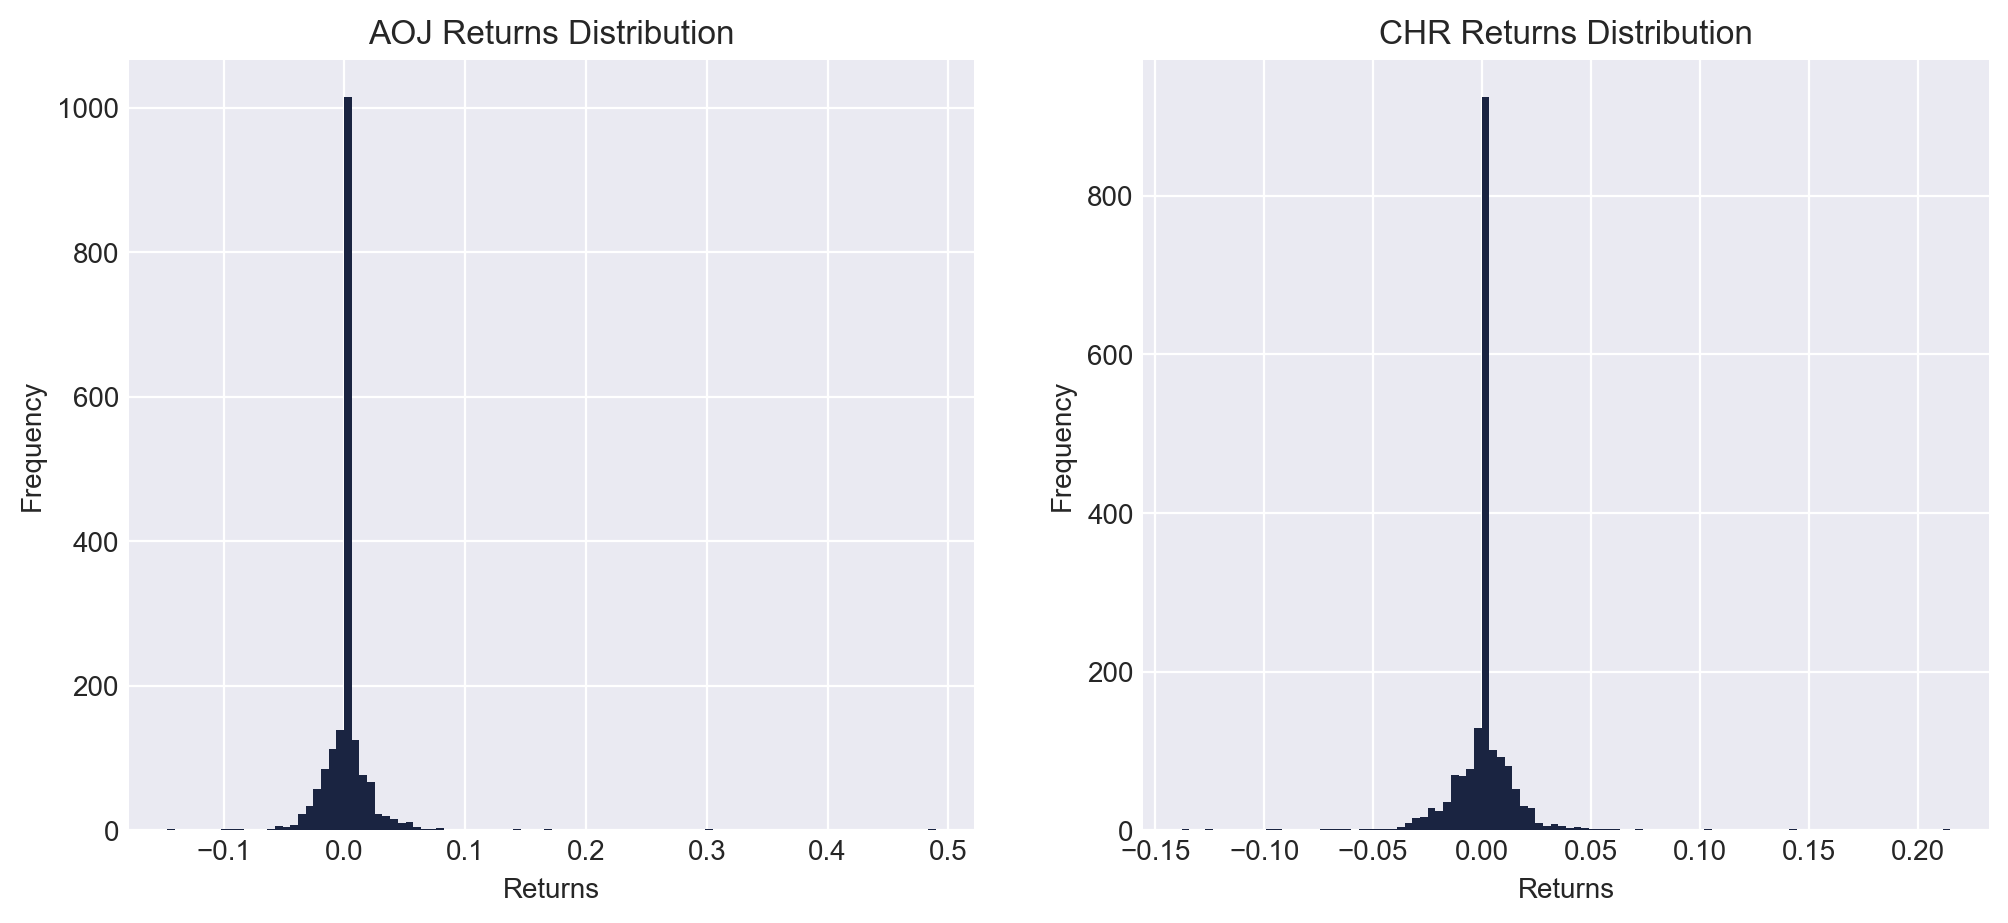

In [14]:
# Visuallize the returns distrubution of AOJ
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(returns_df.loc[:, 'AOJ'], bins=100)
axs[0].set(xlabel='Returns', ylabel='Frequency', title='AOJ Returns Distribution')

axs[1].hist(returns_df.loc[:, 'CHR'], bins=100)
axs[1].set(xlabel='Returns', ylabel='Frequency', title='CHR Returns Distribution')

plt.show()

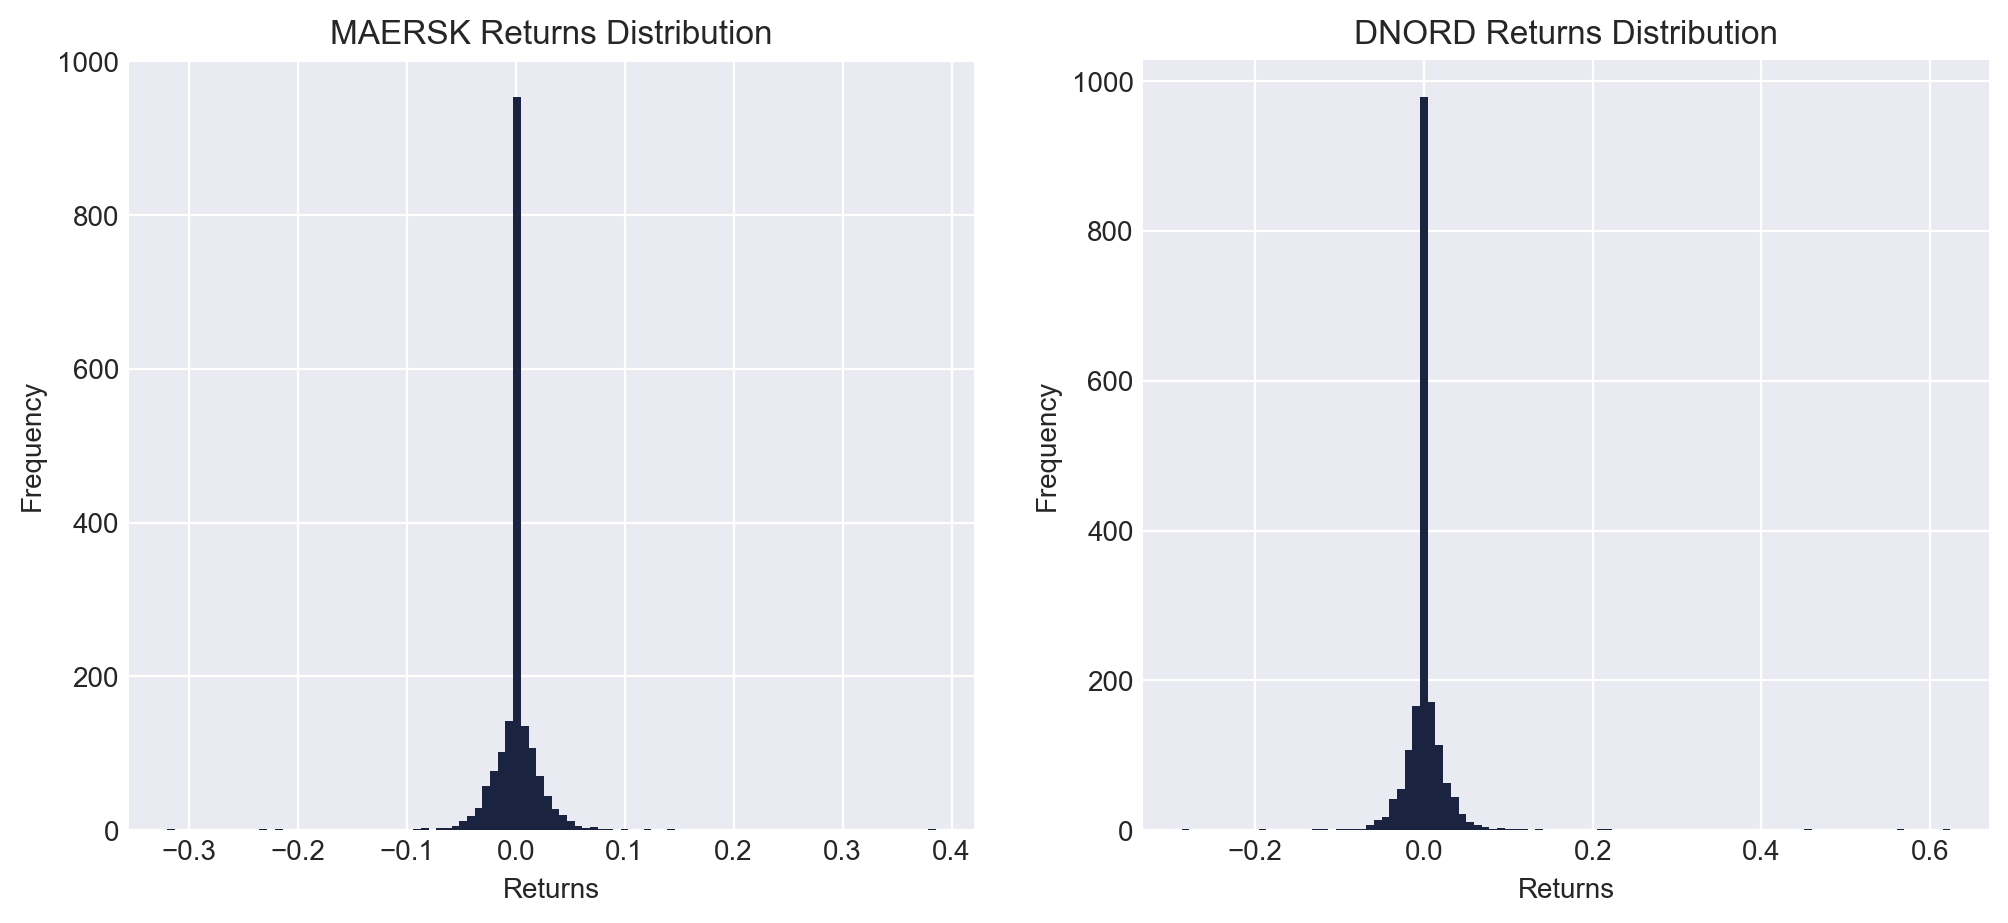

In [15]:
# Visuallize the returns distrubution of AOJ
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(returns_df.loc[:, 'MAERSK'], bins=100)
axs[0].set(xlabel='Returns', ylabel='Frequency', title='MAERSK Returns Distribution')

axs[1].hist(returns_df.loc[:, 'DNORD'], bins=100)
axs[1].set(xlabel='Returns', ylabel='Frequency', title='DNORD Returns Distribution')

plt.show()

### Correlation of the returns

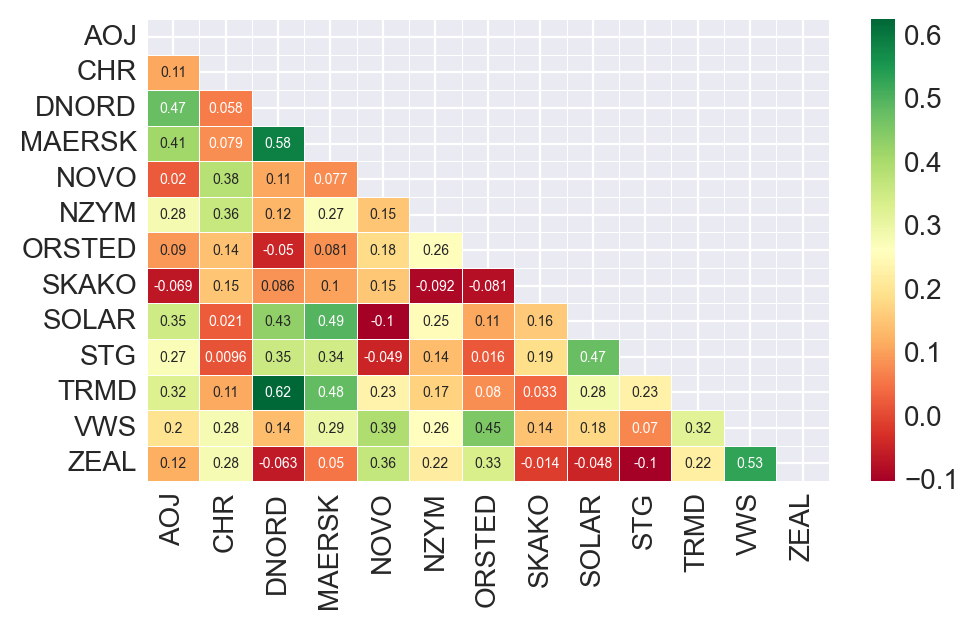

In [16]:
r_corr_matrix = returns_df.corr()

mask = np.zeros_like(r_corr_matrix)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(r_corr_matrix, annot=True, mask=mask, cmap='RdYlGn', linewidths=0.2, annot_kws={'size': 5});

## Portfolio optimization

In [34]:
n_days = 260
n_portfolios = 100_000
n_assets = len(stocks_names)
avg_returns = returns_df.mean() * n_days
avg_returns = avg_returns + dividends
cov_matrix = returns_df.cov() * n_days

In [35]:
np.random.seed(0)
weights = np.random.random(size=(n_portfolios, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

In [36]:
portf_rtns = np.dot(weights, avg_returns)

portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(np.dot(weights[i].T, 
                                    np.dot(cov_matrix, weights[i]))))
portf_vol = np.array(portf_vol)  
portf_sharpe_ratio = (portf_rtns - danish_2y_yield) / portf_vol

In [37]:
portf_results_df = pd.DataFrame({'returns': portf_rtns,
                                 'volatility': portf_vol,
                                 'sharpe_ratio': portf_sharpe_ratio})

In [38]:
n_points = 100
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), 
                            portf_results_df.returns.max(), 
                           n_points)
portf_rtns_ef = np.round(portf_rtns_ef, 2)    
portf_rtns = np.round(portf_rtns, 2)

for point_index in range(n_points):
    if portf_rtns_ef[point_index] not in portf_rtns:
        indices_to_skip.append(point_index)
        continue
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index])
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))
    
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

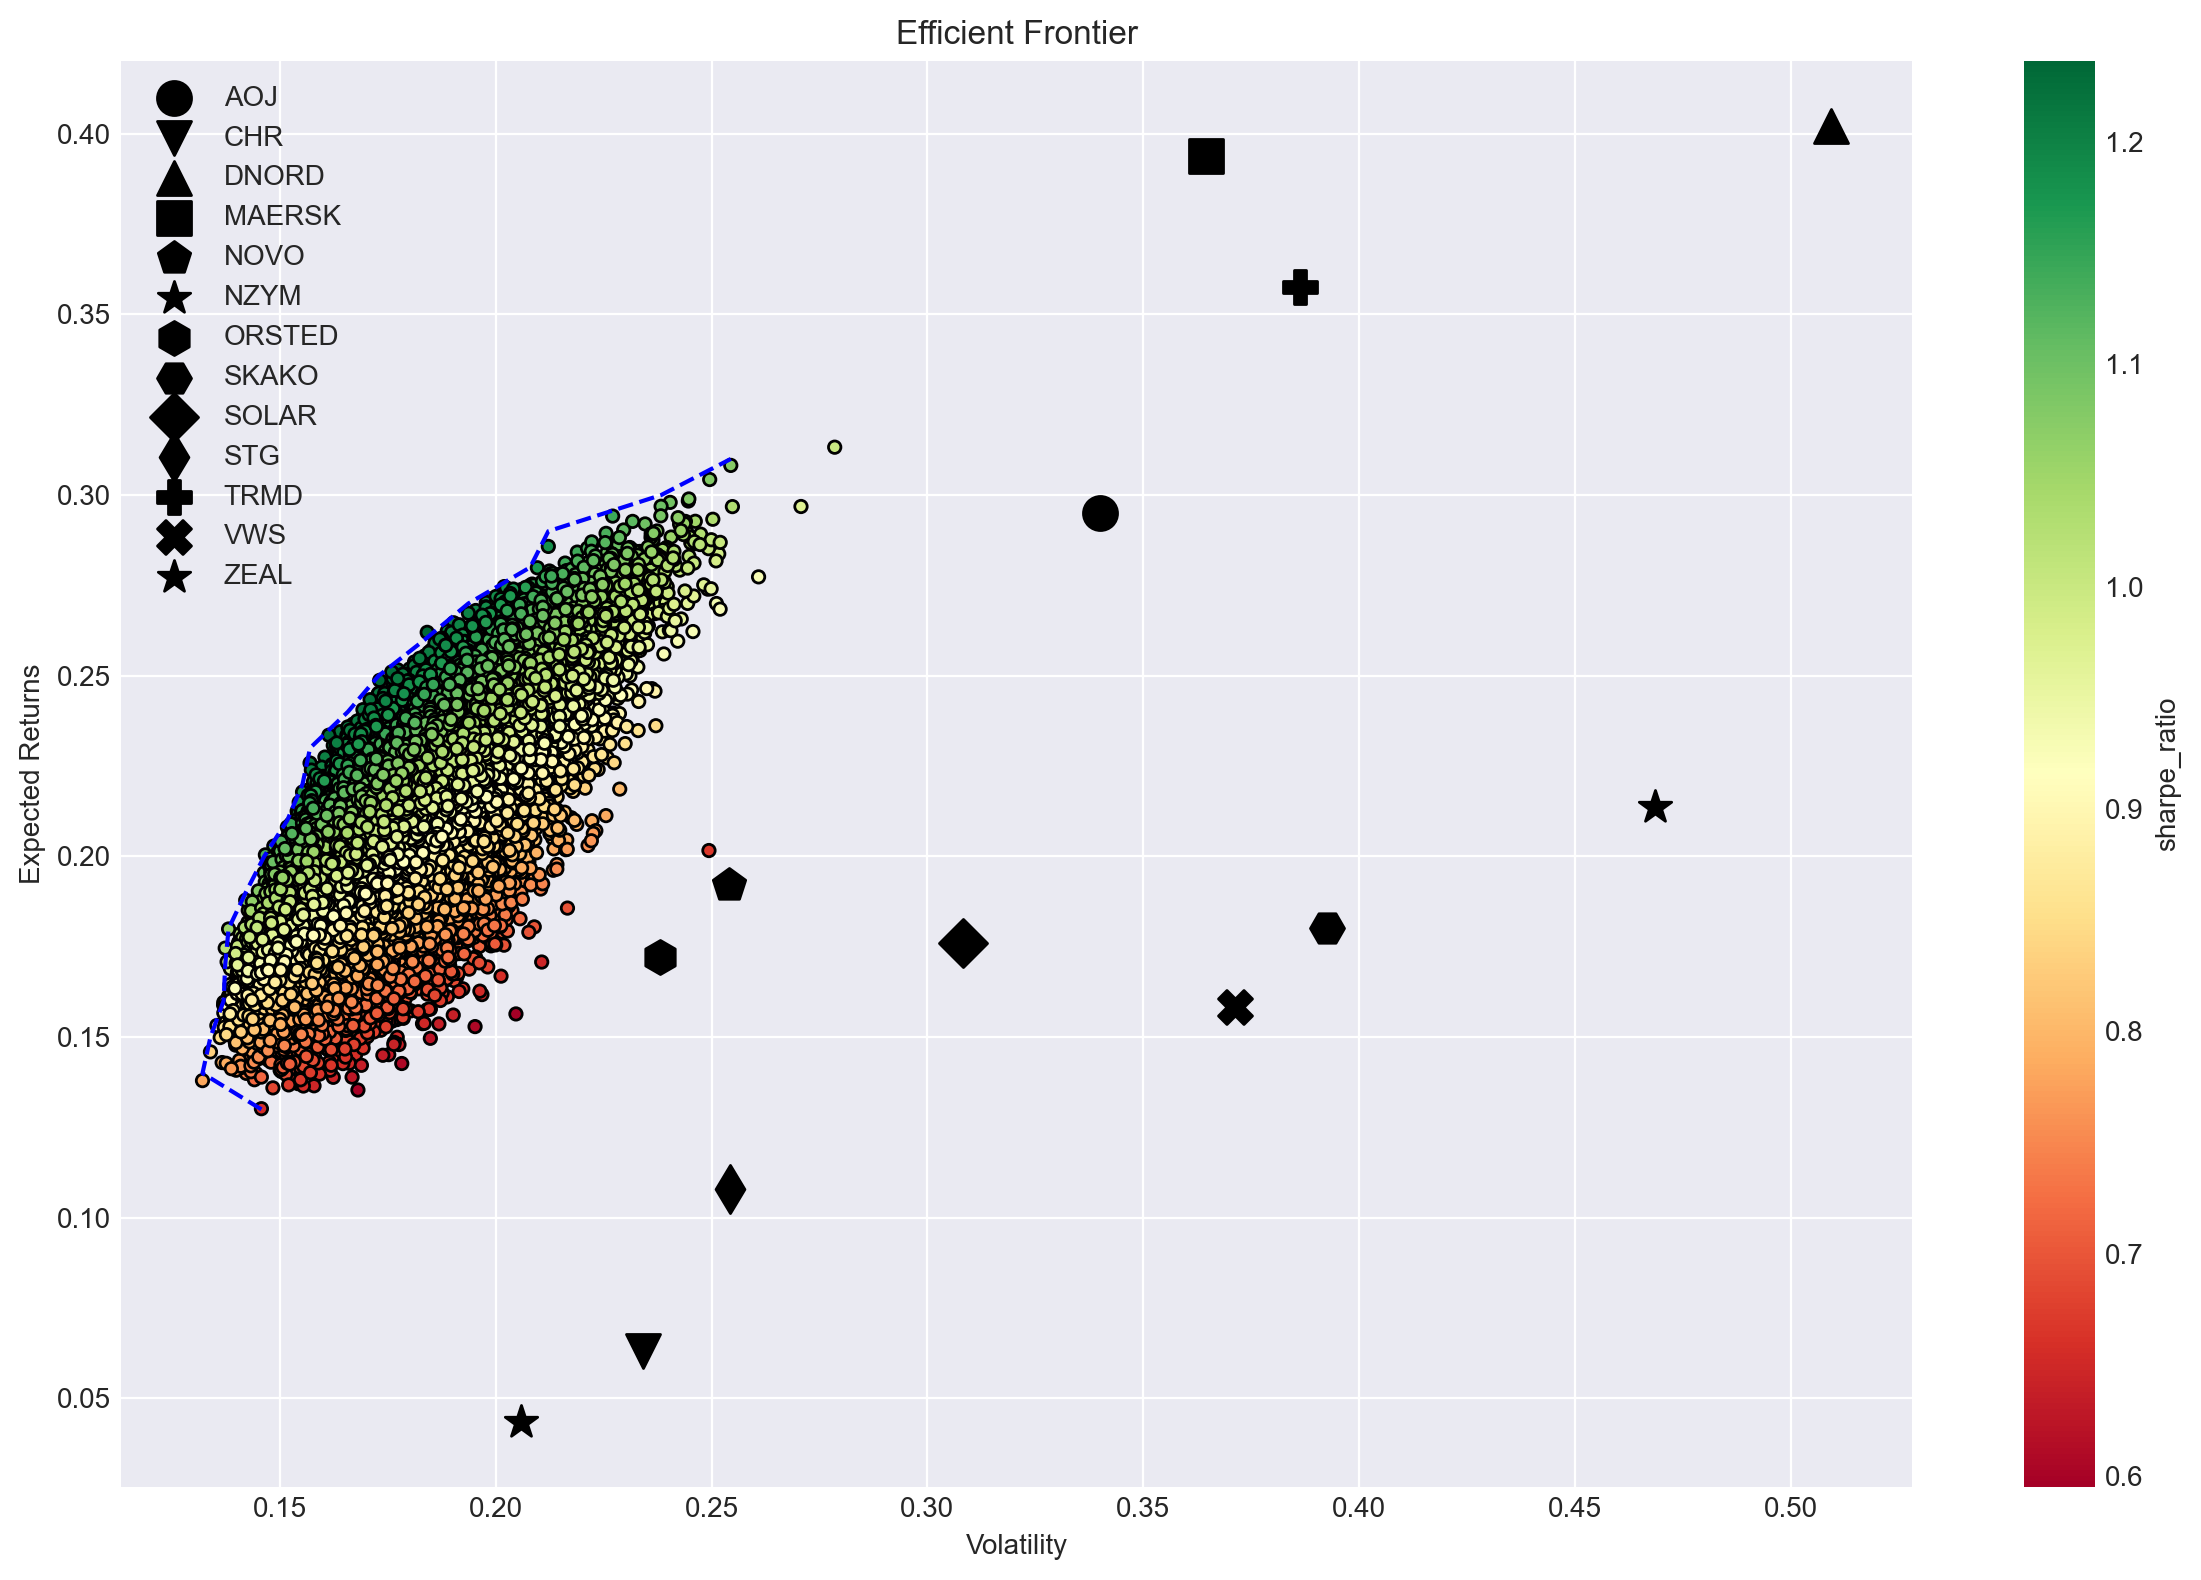

In [39]:
MARKS = ['o', 'v', '^', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X', '*']

fig, ax = plt.subplots(figsize=(12, 8))
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_matrix.iloc[asset_index, asset_index]), 
                y=avg_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='black',
                label=stocks_names[asset_index])
ax.legend()

plt.tight_layout()
plt.show()

### Max sharpe ratio portfolio

Let's now find the *Maximum Sharpe Ration Portfolio* which is the portfolio with maximum sharpe ratio. This portfolio can be obtained solving the following non linear program:

$$
\begin{align}
\min_{w} & - \frac{\boldsymbol w^T \boldsymbol \mu - r_f}{\sqrt{\boldsymbol w^T C \boldsymbol w}}  &\\
\text{s.t.: } & \sum_{i=1}^N w_i = 1 \\
& w_i \ge 0 & \forall i \in \{1, \cdots, N\}
\end{align}
$$

In [40]:
def get_portf_rtn(w, avg_rtns):
    return np.sum(avg_rtns * w)

def get_portf_vol(w, avg_rtns, cov_mat):
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

def get_optimal_portfolio(f_obj, constraints, args, bounds):
    initial_guess = n_assets * [1. / n_assets, ]
    return sco.minimize(f_obj,
                        x0=initial_guess,
                        args=args,
                        method='SLSQP',
                        bounds=bounds,
                        constraints=constraints)

def get_efficient_frontier(avg_rtns, cov_mat, rtns_range):

    efficient_portfolios = []

    n_assets = len(avg_returns)
    args = (avg_returns, cov_mat)
    bounds = tuple((0,1) for asset in range(n_assets))
    initial_guess = n_assets * [1. / n_assets, ]

    for ret in rtns_range:
        constraints = ({'type': 'eq',
                        'fun': lambda x: get_portf_rtn(x, avg_rtns) - ret},
                       {'type': 'eq',
                        'fun': lambda x: np.sum(x) - 1})
        efficient_portfolio = get_optimal_portfolio(f_obj=get_portf_vol,
                                           args=args,
                                           constraints=constraints,
                                           bounds=bounds)
        efficient_portfolios.append(efficient_portfolio)

    return efficient_portfolios

In [41]:
def neg_sharpe_ratio(w, avg_rtns, cov_mat, rf_rate):
    portf_returns = np.sum(avg_rtns * w)
    portf_volatility = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))
    portf_sharpe_ratio = (portf_returns - rf_rate) / portf_volatility
    return -portf_sharpe_ratio

In [42]:
RF_RATE = 0
args = (avg_returns, cov_matrix, RF_RATE)
constraints = ({'type': 'eq',
                'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0,1) for asset in range(n_assets))
max_sharpe_portf = get_optimal_portfolio(f_obj=neg_sharpe_ratio,
                                        args=args,
                                        constraints=constraints,
                                        bounds=bounds)

In [43]:
max_sharpe_portf_w = max_sharpe_portf['x']
max_sharpe_portf = {'Return': get_portf_rtn(max_sharpe_portf_w,
                                            avg_returns),
                    'Volatility': get_portf_vol(max_sharpe_portf_w,
                                                avg_returns,
                                                cov_matrix),
                    'Sharpe Ratio': -max_sharpe_portf['fun']}

In [44]:
rtns_range = np.linspace(-0.22, 0.50, 200)

In [45]:
efficient_portfolios = get_efficient_frontier(avg_returns, 
                                              cov_matrix, 
                                              rtns_range)

In [ ]:
vols_range = [x['fun'] for x in efficient_portfolios]

In [ ]:
min_vol_ind = np.argmin(vols_range)
min_vol_portf_rtn = rtns_range[min_vol_ind]
min_vol_portf_vol = efficient_portfolios[min_vol_ind]['fun']

min_vol_portf = {'Return': min_vol_portf_rtn,
                 'Volatility': min_vol_portf_vol,
                 'Sharpe Ratio': ((min_vol_portf_rtn - danish_2y_yield) / 
                                  min_vol_portf_vol)}

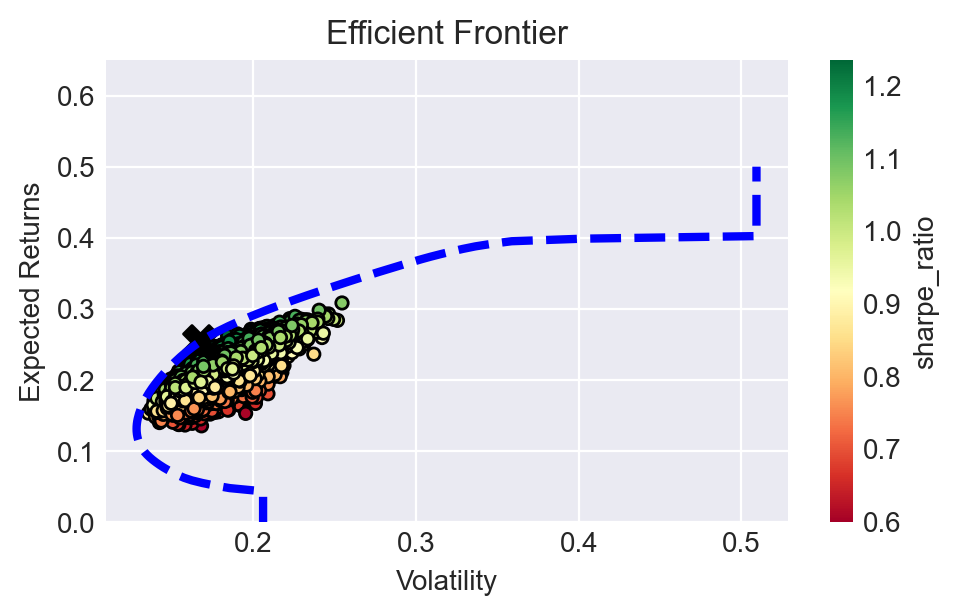

In [ ]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility',
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black',
                      ax=ax)
ax.plot(vols_range, rtns_range, 'b--', linewidth=3)
ax.set(xlabel='Volatility',
       ylabel='Expected Returns',
       title='Efficient Frontier')
ax.scatter(x=max_sharpe_portf['Volatility'],
                y=max_sharpe_portf['Return'],
                marker='X',
                s=150,
                color='black',
                label='MSR')

plt.ylim(0.00,0.65)
plt.show()

In [ ]:
print('Maximum Sharpe Ratio portfolio ----')
print('Performance')

for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)

print('\nWeights')
for x, y in zip(stocks_names, max_sharpe_portf_w):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
Return: 25.40% Volatility: 16.73% Sharpe Ratio: 151.77% 
Weights
AOJ: 15.78% CHR: 0.00% DNORD: 0.00% MAERSK: 18.57% NOVO: 20.28% NZYM: 0.00% ORSTED: 25.54% SKAKO: 11.07% SOLAR: 0.00% STG: 0.00% TRMD: 8.76% VWS: 0.00% ZEAL: 0.00% 